## Imports

In [1]:
from scipy import signal
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
from sklearn.decomposition import PCA
import seaborn as sb
from scipy.sparse.linalg import eigsh
from sklearn.decomposition import PCA
from scipy import io
from scipy.sparse.linalg import eigsh

## Load and prepare Data

In [3]:
dat = io.loadmat('calcium_data/V1/natimg2800_M170714_MP032_2017-09-14.mat')

resp = dat['stim'][0]['resp'][0] # stim x neurons
spont = dat['stim'][0]['spont'][0] # timepts x neurons
istim = (dat['stim'][0]['istim'][0]).astype(np.int32) # stim ids 
istim -= 1 # get out of MATLAB convention
istim = istim[:,0]
nimg = istim.max() # these are blank stims (exclude them)
resp = resp[istim<nimg, :]
istim = istim[istim<nimg]

# subtract spont (32D)
mu = spont.mean(axis=0)
sd = spont.std(axis=0) + 1e-6
resp = (resp - mu) / sd
spont = (spont - mu) / sd
sv,u = eigsh(spont.T @ spont, k=32)
resp = resp - (resp @ u) @ u.T

# mean center each neuron
resp -= resp.mean(axis=0)

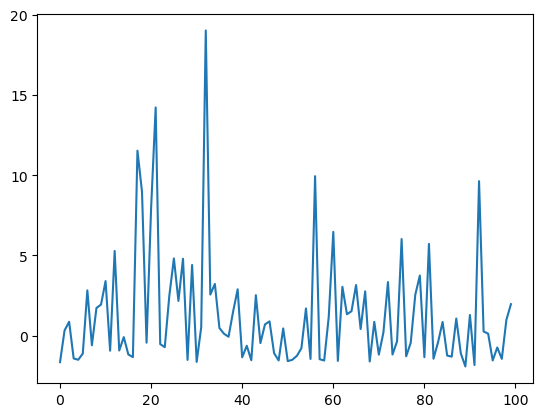

In [8]:
plt.plot(resp[:100,0])

## Utils

In [4]:
def get_powerlaw(ss, trange):
    ''' fit exponent to variance curve'''
    logss = np.log(np.abs(ss))
    y = logss[trange][:,np.newaxis]
    trange += 1
    nt = trange.size
    x = np.concatenate((-np.log(trange)[:,np.newaxis], np.ones((nt,1))), axis=1)
    w = 1.0 / trange.astype(np.float32)[:,np.newaxis]
    b = np.linalg.solve(x.T @ (x * w), (w * x).T @ y).flatten()
    
    allrange = np.arange(0, ss.size).astype(int) + 1
    x = np.concatenate((-np.log(allrange)[:,np.newaxis], np.ones((ss.size,1))), axis=1)
    ypred = np.exp((x * b).sum(axis=1))
    alpha = b[0]
    return alpha,ypred

def shuff_cvPCA(X, nshuff=5):
    ''' X is 2 x stimuli x neurons '''
    nc = min(1024, X.shape[1])
    ss=np.zeros((nshuff,nc))
    for k in range(nshuff):
        iflip = np.random.rand(X.shape[1]) > 0.5
        X0 = X.copy()
        X0[0,iflip] = X[1,iflip]
        X0[1,iflip] = X[0,iflip]
        ss[k]=cvPCA(X0)
    return ss

def cvPCA(X):
    ''' X is 2 x stimuli x neurons '''
    pca = PCA(n_components=min(1024, X.shape[1])).fit(X[0].T)
    u = pca.components_.T
    sv = pca.singular_values_
    
    xproj = X[0].T @ (u / sv)
    cproj0 = X[0] @ xproj
    cproj1 = X[1] @ xproj
    ss = (cproj0 * cproj1).sum(axis=0)
    return ss

## Powerlaw analysis

In [4]:
### sanity check - decent signal variance ?
# split stimuli into two repeats
NN = resp.shape[1]
sresp = np.zeros((2, nimg, NN), np.float64)
inan = np.zeros((nimg,), np.bool)
for n in range(nimg):
    ist = (istim==n).nonzero()[0]
    i1 = ist[:int(ist.size/2)]
    i2 = ist[int(ist.size/2):]
    # check if two repeats of stim
    if np.logical_or(i2.size < 1, i1.size < 1):
        inan[n] = 1
    else:
        sresp[0, n, :] = resp[i1, :].mean(axis=0)
        sresp[1, n, :] = resp[i2, :].mean(axis=0)
        
# remove image responses without two repeats
sresp = sresp[:,~inan,:]
    
snorm = sresp - sresp.mean(axis=1)[:,np.newaxis,:]
snorm = snorm / (snorm.std(axis=1)[:,np.newaxis,:] + 1e-6)

cc = (snorm[0].T @ snorm[1]) / sresp.shape[1]

print('fraction of signal variance: %2.3f'%np.diag(cc).mean())

C:\Users\Afernandez\AppData\Local\Temp\ipykernel_30252\1566601546.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  inan = np.zeros((nimg,), np.bool)


fraction of signal variance: 0.165


In [5]:
### sanity check - decent decoding ?
# 1 nearest neighbor decoder    
# (mean already subtracted)
cc = sresp[0] @ sresp[1].T
cc /= (sresp[0]**2).sum()
cc /= (sresp[1]**2).sum()
nstims = sresp.shape[1]
print('decoding accuracy: %2.3f'%(cc.argmax(axis=1)==np.arange(0,nstims,1,int)).mean())

decoding accuracy: 0.412


In [ ]:
### sanity check - is the powerlaw close to 1 ?
# powerlaw

# compute cvPCA
ss = shuff_cvPCA(sresp)

# compute powerlaw of averaged shuffles
ss = ss.mean(axis=0)
alpha,ypred = get_powerlaw(ss/ss.sum(), np.arange(11,5e2).astype(int))  
print('powerlaw, alpha=%2.3f'%alpha)

plt.loglog(np.arange(0,ss.size)+1, ss/ss.sum())
plt.loglog(np.arange(0,ss.size)+1, ypred, c='k')
plt.show()

In [6]:
data = sresp[0]

In [7]:
data.shape

(2800, 9476)

## Pairwise correlations

In [12]:
def compute_pairwise_correlations(data):
    """
    Compute the overall pairwise correlation level for each session of each animal.

    Parameters:
    data (dict): A nested dictionary where the first key is the animal ID and the second key is the session ID, 
                 mapping to a data matrix for that session.
    p_value_threshold (float): The threshold for considering correlations as significant.

    Returns:
    correlations (dict): A nested dictionary with the mean correlation for each session of each animal.
    """
    n_neurons = data.shape[1]
    correlations = []
    for i in range(n_neurons):
        print(str(i)+'/'+str(n_neurons))
        for j in range(i+1, n_neurons):
            corr, p_value = pearsonr(data[:, i], data[:, j])
            correlations.append(corr)

    return correlations

In [13]:
correlations = compute_pairwise_correlations(data)

0/9476
1/9476
2/9476
3/9476
4/9476
5/9476
6/9476
7/9476
8/9476
9/9476
10/9476
11/9476
12/9476
13/9476
14/9476
15/9476
16/9476
17/9476
18/9476
19/9476
20/9476
21/9476
22/9476
23/9476
24/9476
25/9476
26/9476
27/9476
28/9476
29/9476
30/9476
31/9476
32/9476
33/9476
34/9476
35/9476
36/9476
37/9476
38/9476
39/9476
40/9476
41/9476
42/9476
43/9476
44/9476
45/9476
46/9476
47/9476
48/9476
49/9476
50/9476
51/9476
52/9476
53/9476
54/9476
55/9476
56/9476
57/9476
58/9476
59/9476
60/9476
61/9476
62/9476
63/9476
64/9476
65/9476
66/9476
67/9476
68/9476
69/9476
70/9476
71/9476
72/9476
73/9476
74/9476
75/9476
76/9476
77/9476
78/9476
79/9476
80/9476
81/9476
82/9476
83/9476
84/9476
85/9476
86/9476
87/9476
88/9476
89/9476
90/9476
91/9476
92/9476
93/9476
94/9476
95/9476
96/9476
97/9476
98/9476
99/9476
100/9476
101/9476
102/9476
103/9476
104/9476
105/9476
106/9476
107/9476
108/9476
109/9476
110/9476
111/9476
112/9476
113/9476
114/9476
115/9476
116/9476
117/9476
118/9476
119/9476
120/9476
121/9476
122/9476
123

923/9476
924/9476
925/9476
926/9476
927/9476
928/9476
929/9476
930/9476
931/9476
932/9476
933/9476
934/9476
935/9476
936/9476
937/9476
938/9476
939/9476
940/9476
941/9476
942/9476
943/9476
944/9476
945/9476
946/9476
947/9476
948/9476
949/9476
950/9476
951/9476
952/9476
953/9476
954/9476
955/9476
956/9476
957/9476
958/9476
959/9476
960/9476
961/9476
962/9476
963/9476
964/9476
965/9476
966/9476
967/9476
968/9476
969/9476
970/9476
971/9476
972/9476
973/9476
974/9476
975/9476
976/9476
977/9476
978/9476
979/9476
980/9476
981/9476
982/9476
983/9476
984/9476
985/9476
986/9476
987/9476
988/9476
989/9476
990/9476
991/9476
992/9476
993/9476
994/9476
995/9476
996/9476
997/9476
998/9476
999/9476
1000/9476
1001/9476
1002/9476
1003/9476
1004/9476
1005/9476
1006/9476
1007/9476
1008/9476
1009/9476
1010/9476
1011/9476
1012/9476
1013/9476
1014/9476
1015/9476
1016/9476
1017/9476
1018/9476
1019/9476
1020/9476
1021/9476
1022/9476
1023/9476
1024/9476
1025/9476
1026/9476
1027/9476
1028/9476
1029/9476
1030/94

1750/9476
1751/9476
1752/9476
1753/9476
1754/9476
1755/9476
1756/9476
1757/9476
1758/9476
1759/9476
1760/9476
1761/9476
1762/9476
1763/9476
1764/9476
1765/9476
1766/9476
1767/9476
1768/9476
1769/9476
1770/9476
1771/9476
1772/9476
1773/9476
1774/9476
1775/9476
1776/9476
1777/9476
1778/9476
1779/9476
1780/9476
1781/9476
1782/9476
1783/9476
1784/9476
1785/9476
1786/9476
1787/9476
1788/9476
1789/9476
1790/9476
1791/9476
1792/9476
1793/9476
1794/9476
1795/9476
1796/9476
1797/9476
1798/9476
1799/9476
1800/9476
1801/9476
1802/9476
1803/9476
1804/9476
1805/9476
1806/9476
1807/9476
1808/9476
1809/9476
1810/9476
1811/9476
1812/9476
1813/9476
1814/9476
1815/9476
1816/9476
1817/9476
1818/9476
1819/9476
1820/9476
1821/9476
1822/9476
1823/9476
1824/9476
1825/9476
1826/9476
1827/9476
1828/9476
1829/9476
1830/9476
1831/9476
1832/9476
1833/9476
1834/9476
1835/9476
1836/9476
1837/9476
1838/9476
1839/9476
1840/9476
1841/9476
1842/9476
1843/9476
1844/9476
1845/9476
1846/9476
1847/9476
1848/9476
1849/9476


2570/9476
2571/9476
2572/9476
2573/9476
2574/9476
2575/9476
2576/9476
2577/9476
2578/9476
2579/9476
2580/9476
2581/9476
2582/9476
2583/9476
2584/9476
2585/9476
2586/9476
2587/9476
2588/9476
2589/9476
2590/9476
2591/9476
2592/9476
2593/9476
2594/9476
2595/9476
2596/9476
2597/9476
2598/9476
2599/9476
2600/9476
2601/9476
2602/9476
2603/9476
2604/9476
2605/9476
2606/9476
2607/9476
2608/9476
2609/9476
2610/9476
2611/9476
2612/9476
2613/9476
2614/9476
2615/9476
2616/9476
2617/9476
2618/9476
2619/9476
2620/9476
2621/9476
2622/9476
2623/9476
2624/9476
2625/9476
2626/9476
2627/9476
2628/9476
2629/9476
2630/9476
2631/9476
2632/9476
2633/9476
2634/9476
2635/9476
2636/9476
2637/9476
2638/9476
2639/9476
2640/9476
2641/9476
2642/9476
2643/9476
2644/9476
2645/9476
2646/9476
2647/9476
2648/9476
2649/9476
2650/9476
2651/9476
2652/9476
2653/9476
2654/9476
2655/9476
2656/9476
2657/9476
2658/9476
2659/9476
2660/9476
2661/9476
2662/9476
2663/9476
2664/9476
2665/9476
2666/9476
2667/9476
2668/9476
2669/9476


3390/9476
3391/9476
3392/9476
3393/9476
3394/9476
3395/9476
3396/9476
3397/9476
3398/9476
3399/9476
3400/9476
3401/9476
3402/9476
3403/9476
3404/9476
3405/9476
3406/9476
3407/9476
3408/9476
3409/9476
3410/9476
3411/9476
3412/9476
3413/9476
3414/9476
3415/9476
3416/9476
3417/9476
3418/9476
3419/9476
3420/9476
3421/9476
3422/9476
3423/9476
3424/9476
3425/9476
3426/9476
3427/9476
3428/9476
3429/9476
3430/9476
3431/9476
3432/9476
3433/9476
3434/9476
3435/9476
3436/9476
3437/9476
3438/9476
3439/9476
3440/9476
3441/9476
3442/9476
3443/9476
3444/9476
3445/9476
3446/9476
3447/9476
3448/9476
3449/9476
3450/9476
3451/9476
3452/9476
3453/9476
3454/9476
3455/9476
3456/9476
3457/9476
3458/9476
3459/9476
3460/9476
3461/9476
3462/9476
3463/9476
3464/9476
3465/9476
3466/9476
3467/9476
3468/9476
3469/9476
3470/9476
3471/9476
3472/9476
3473/9476
3474/9476
3475/9476
3476/9476
3477/9476
3478/9476
3479/9476
3480/9476
3481/9476
3482/9476
3483/9476
3484/9476
3485/9476
3486/9476
3487/9476
3488/9476
3489/9476


4210/9476
4211/9476
4212/9476
4213/9476
4214/9476
4215/9476
4216/9476
4217/9476
4218/9476
4219/9476
4220/9476
4221/9476
4222/9476
4223/9476
4224/9476
4225/9476
4226/9476
4227/9476
4228/9476
4229/9476
4230/9476
4231/9476
4232/9476
4233/9476
4234/9476
4235/9476
4236/9476
4237/9476
4238/9476
4239/9476
4240/9476
4241/9476
4242/9476
4243/9476
4244/9476
4245/9476
4246/9476
4247/9476
4248/9476
4249/9476
4250/9476
4251/9476
4252/9476
4253/9476
4254/9476
4255/9476
4256/9476
4257/9476
4258/9476
4259/9476
4260/9476
4261/9476
4262/9476
4263/9476
4264/9476
4265/9476
4266/9476
4267/9476
4268/9476
4269/9476
4270/9476
4271/9476
4272/9476
4273/9476
4274/9476
4275/9476
4276/9476
4277/9476
4278/9476
4279/9476
4280/9476
4281/9476
4282/9476
4283/9476
4284/9476
4285/9476
4286/9476
4287/9476
4288/9476
4289/9476
4290/9476
4291/9476
4292/9476
4293/9476
4294/9476
4295/9476
4296/9476
4297/9476
4298/9476
4299/9476
4300/9476
4301/9476
4302/9476
4303/9476
4304/9476
4305/9476
4306/9476
4307/9476
4308/9476
4309/9476


5030/9476
5031/9476
5032/9476
5033/9476
5034/9476
5035/9476
5036/9476
5037/9476
5038/9476
5039/9476
5040/9476
5041/9476
5042/9476
5043/9476
5044/9476
5045/9476
5046/9476
5047/9476
5048/9476
5049/9476
5050/9476
5051/9476
5052/9476
5053/9476
5054/9476
5055/9476
5056/9476
5057/9476
5058/9476
5059/9476
5060/9476
5061/9476
5062/9476
5063/9476
5064/9476
5065/9476
5066/9476
5067/9476
5068/9476
5069/9476
5070/9476
5071/9476
5072/9476
5073/9476
5074/9476
5075/9476
5076/9476
5077/9476
5078/9476
5079/9476
5080/9476
5081/9476
5082/9476
5083/9476
5084/9476
5085/9476
5086/9476
5087/9476
5088/9476
5089/9476
5090/9476
5091/9476
5092/9476
5093/9476
5094/9476
5095/9476
5096/9476
5097/9476
5098/9476
5099/9476
5100/9476
5101/9476
5102/9476
5103/9476
5104/9476
5105/9476
5106/9476
5107/9476
5108/9476
5109/9476
5110/9476
5111/9476
5112/9476
5113/9476
5114/9476
5115/9476
5116/9476
5117/9476
5118/9476
5119/9476
5120/9476
5121/9476
5122/9476
5123/9476
5124/9476
5125/9476
5126/9476
5127/9476
5128/9476
5129/9476


5850/9476
5851/9476
5852/9476
5853/9476
5854/9476
5855/9476
5856/9476
5857/9476
5858/9476
5859/9476
5860/9476
5861/9476
5862/9476
5863/9476
5864/9476
5865/9476
5866/9476
5867/9476
5868/9476
5869/9476
5870/9476
5871/9476
5872/9476
5873/9476
5874/9476
5875/9476
5876/9476
5877/9476
5878/9476
5879/9476
5880/9476
5881/9476
5882/9476
5883/9476
5884/9476
5885/9476
5886/9476
5887/9476
5888/9476
5889/9476
5890/9476
5891/9476
5892/9476
5893/9476
5894/9476
5895/9476
5896/9476
5897/9476
5898/9476
5899/9476
5900/9476
5901/9476
5902/9476
5903/9476
5904/9476
5905/9476
5906/9476
5907/9476
5908/9476
5909/9476
5910/9476
5911/9476
5912/9476
5913/9476
5914/9476
5915/9476
5916/9476
5917/9476
5918/9476
5919/9476
5920/9476
5921/9476
5922/9476
5923/9476
5924/9476
5925/9476
5926/9476
5927/9476
5928/9476
5929/9476
5930/9476
5931/9476
5932/9476
5933/9476
5934/9476
5935/9476
5936/9476
5937/9476
5938/9476
5939/9476
5940/9476
5941/9476
5942/9476
5943/9476
5944/9476
5945/9476
5946/9476
5947/9476
5948/9476
5949/9476


6670/9476
6671/9476
6672/9476
6673/9476
6674/9476
6675/9476
6676/9476
6677/9476
6678/9476
6679/9476
6680/9476
6681/9476
6682/9476
6683/9476
6684/9476
6685/9476
6686/9476
6687/9476
6688/9476
6689/9476
6690/9476
6691/9476
6692/9476
6693/9476
6694/9476
6695/9476
6696/9476
6697/9476
6698/9476
6699/9476
6700/9476
6701/9476
6702/9476
6703/9476
6704/9476
6705/9476
6706/9476
6707/9476
6708/9476
6709/9476
6710/9476
6711/9476
6712/9476
6713/9476
6714/9476
6715/9476
6716/9476
6717/9476
6718/9476
6719/9476
6720/9476
6721/9476
6722/9476
6723/9476
6724/9476
6725/9476
6726/9476
6727/9476
6728/9476
6729/9476
6730/9476
6731/9476
6732/9476
6733/9476
6734/9476
6735/9476
6736/9476
6737/9476
6738/9476
6739/9476
6740/9476
6741/9476
6742/9476
6743/9476
6744/9476
6745/9476
6746/9476
6747/9476
6748/9476
6749/9476
6750/9476
6751/9476
6752/9476
6753/9476
6754/9476
6755/9476
6756/9476
6757/9476
6758/9476
6759/9476
6760/9476
6761/9476
6762/9476
6763/9476
6764/9476
6765/9476
6766/9476
6767/9476
6768/9476
6769/9476


7490/9476
7491/9476
7492/9476
7493/9476
7494/9476
7495/9476
7496/9476
7497/9476
7498/9476
7499/9476
7500/9476
7501/9476
7502/9476
7503/9476
7504/9476
7505/9476
7506/9476
7507/9476
7508/9476
7509/9476
7510/9476
7511/9476
7512/9476
7513/9476
7514/9476
7515/9476
7516/9476
7517/9476
7518/9476
7519/9476
7520/9476
7521/9476
7522/9476
7523/9476
7524/9476
7525/9476
7526/9476
7527/9476
7528/9476
7529/9476
7530/9476
7531/9476
7532/9476
7533/9476
7534/9476
7535/9476
7536/9476
7537/9476
7538/9476
7539/9476
7540/9476
7541/9476
7542/9476
7543/9476
7544/9476
7545/9476
7546/9476
7547/9476
7548/9476
7549/9476
7550/9476
7551/9476
7552/9476
7553/9476
7554/9476
7555/9476
7556/9476
7557/9476
7558/9476
7559/9476
7560/9476
7561/9476
7562/9476
7563/9476
7564/9476
7565/9476
7566/9476
7567/9476
7568/9476
7569/9476
7570/9476
7571/9476
7572/9476
7573/9476
7574/9476
7575/9476
7576/9476
7577/9476
7578/9476
7579/9476
7580/9476
7581/9476
7582/9476
7583/9476
7584/9476
7585/9476
7586/9476
7587/9476
7588/9476
7589/9476


8310/9476
8311/9476
8312/9476
8313/9476
8314/9476
8315/9476
8316/9476
8317/9476
8318/9476
8319/9476
8320/9476
8321/9476
8322/9476
8323/9476
8324/9476
8325/9476
8326/9476
8327/9476
8328/9476
8329/9476
8330/9476
8331/9476
8332/9476
8333/9476
8334/9476
8335/9476
8336/9476
8337/9476
8338/9476
8339/9476
8340/9476
8341/9476
8342/9476
8343/9476
8344/9476
8345/9476
8346/9476
8347/9476
8348/9476
8349/9476
8350/9476
8351/9476
8352/9476
8353/9476
8354/9476
8355/9476
8356/9476
8357/9476
8358/9476
8359/9476
8360/9476
8361/9476
8362/9476
8363/9476
8364/9476
8365/9476
8366/9476
8367/9476
8368/9476
8369/9476
8370/9476
8371/9476
8372/9476
8373/9476
8374/9476
8375/9476
8376/9476
8377/9476
8378/9476
8379/9476
8380/9476
8381/9476
8382/9476
8383/9476
8384/9476
8385/9476
8386/9476
8387/9476
8388/9476
8389/9476
8390/9476
8391/9476
8392/9476
8393/9476
8394/9476
8395/9476
8396/9476
8397/9476
8398/9476
8399/9476
8400/9476
8401/9476
8402/9476
8403/9476
8404/9476
8405/9476
8406/9476
8407/9476
8408/9476
8409/9476


9132/9476
9133/9476
9134/9476
9135/9476
9136/9476
9137/9476
9138/9476
9139/9476
9140/9476
9141/9476
9142/9476
9143/9476
9144/9476
9145/9476
9146/9476
9147/9476
9148/9476
9149/9476
9150/9476
9151/9476
9152/9476
9153/9476
9154/9476
9155/9476
9156/9476
9157/9476
9158/9476
9159/9476
9160/9476
9161/9476
9162/9476
9163/9476
9164/9476
9165/9476
9166/9476
9167/9476
9168/9476
9169/9476
9170/9476
9171/9476
9172/9476
9173/9476
9174/9476
9175/9476
9176/9476
9177/9476
9178/9476
9179/9476
9180/9476
9181/9476
9182/9476
9183/9476
9184/9476
9185/9476
9186/9476
9187/9476
9188/9476
9189/9476
9190/9476
9191/9476
9192/9476
9193/9476
9194/9476
9195/9476
9196/9476
9197/9476
9198/9476
9199/9476
9200/9476
9201/9476
9202/9476
9203/9476
9204/9476
9205/9476
9206/9476
9207/9476
9208/9476
9209/9476
9210/9476
9211/9476
9212/9476
9213/9476
9214/9476
9215/9476
9216/9476
9217/9476
9218/9476
9219/9476
9220/9476
9221/9476
9222/9476
9223/9476
9224/9476
9225/9476
9226/9476
9227/9476
9228/9476
9229/9476
9230/9476
9231/9476


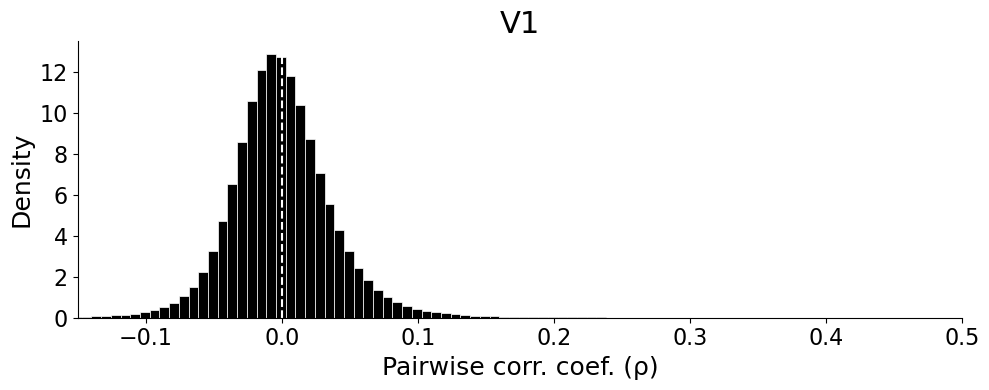

In [21]:
plt.figure(figsize=(10,4))

plt.hist(correlations, bins=200, color='k', alpha=1, edgecolor='white', linewidth=.5, density=True)

plt.axvline(x=np.mean(correlations), color='white', linestyle='--')

plt.xlabel('Pairwise corr. coef. (ρ)', fontsize=18)
#plt.ylabel('No. of neuron pairs', fontsize=18)
plt.ylabel('Density', fontsize=18)

plt.title('V1', fontsize=22)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(-0.15, 0.5)

sb.despine()
plt.tight_layout()
plt.savefig('plots/pairwiseCorrDistr_V1.png', dpi=600)
plt.show()

In [15]:
np.save('results/pairwise_corr_values_calcium_V1.npy', np.array(correlations))

In [2]:
correlations_v1 = np.load('results/pairwise_corr_values_calcium_V1.npy')
correlations_ca1 = np.load('results/pairwise_corr_values_calcium_CA1.npy')

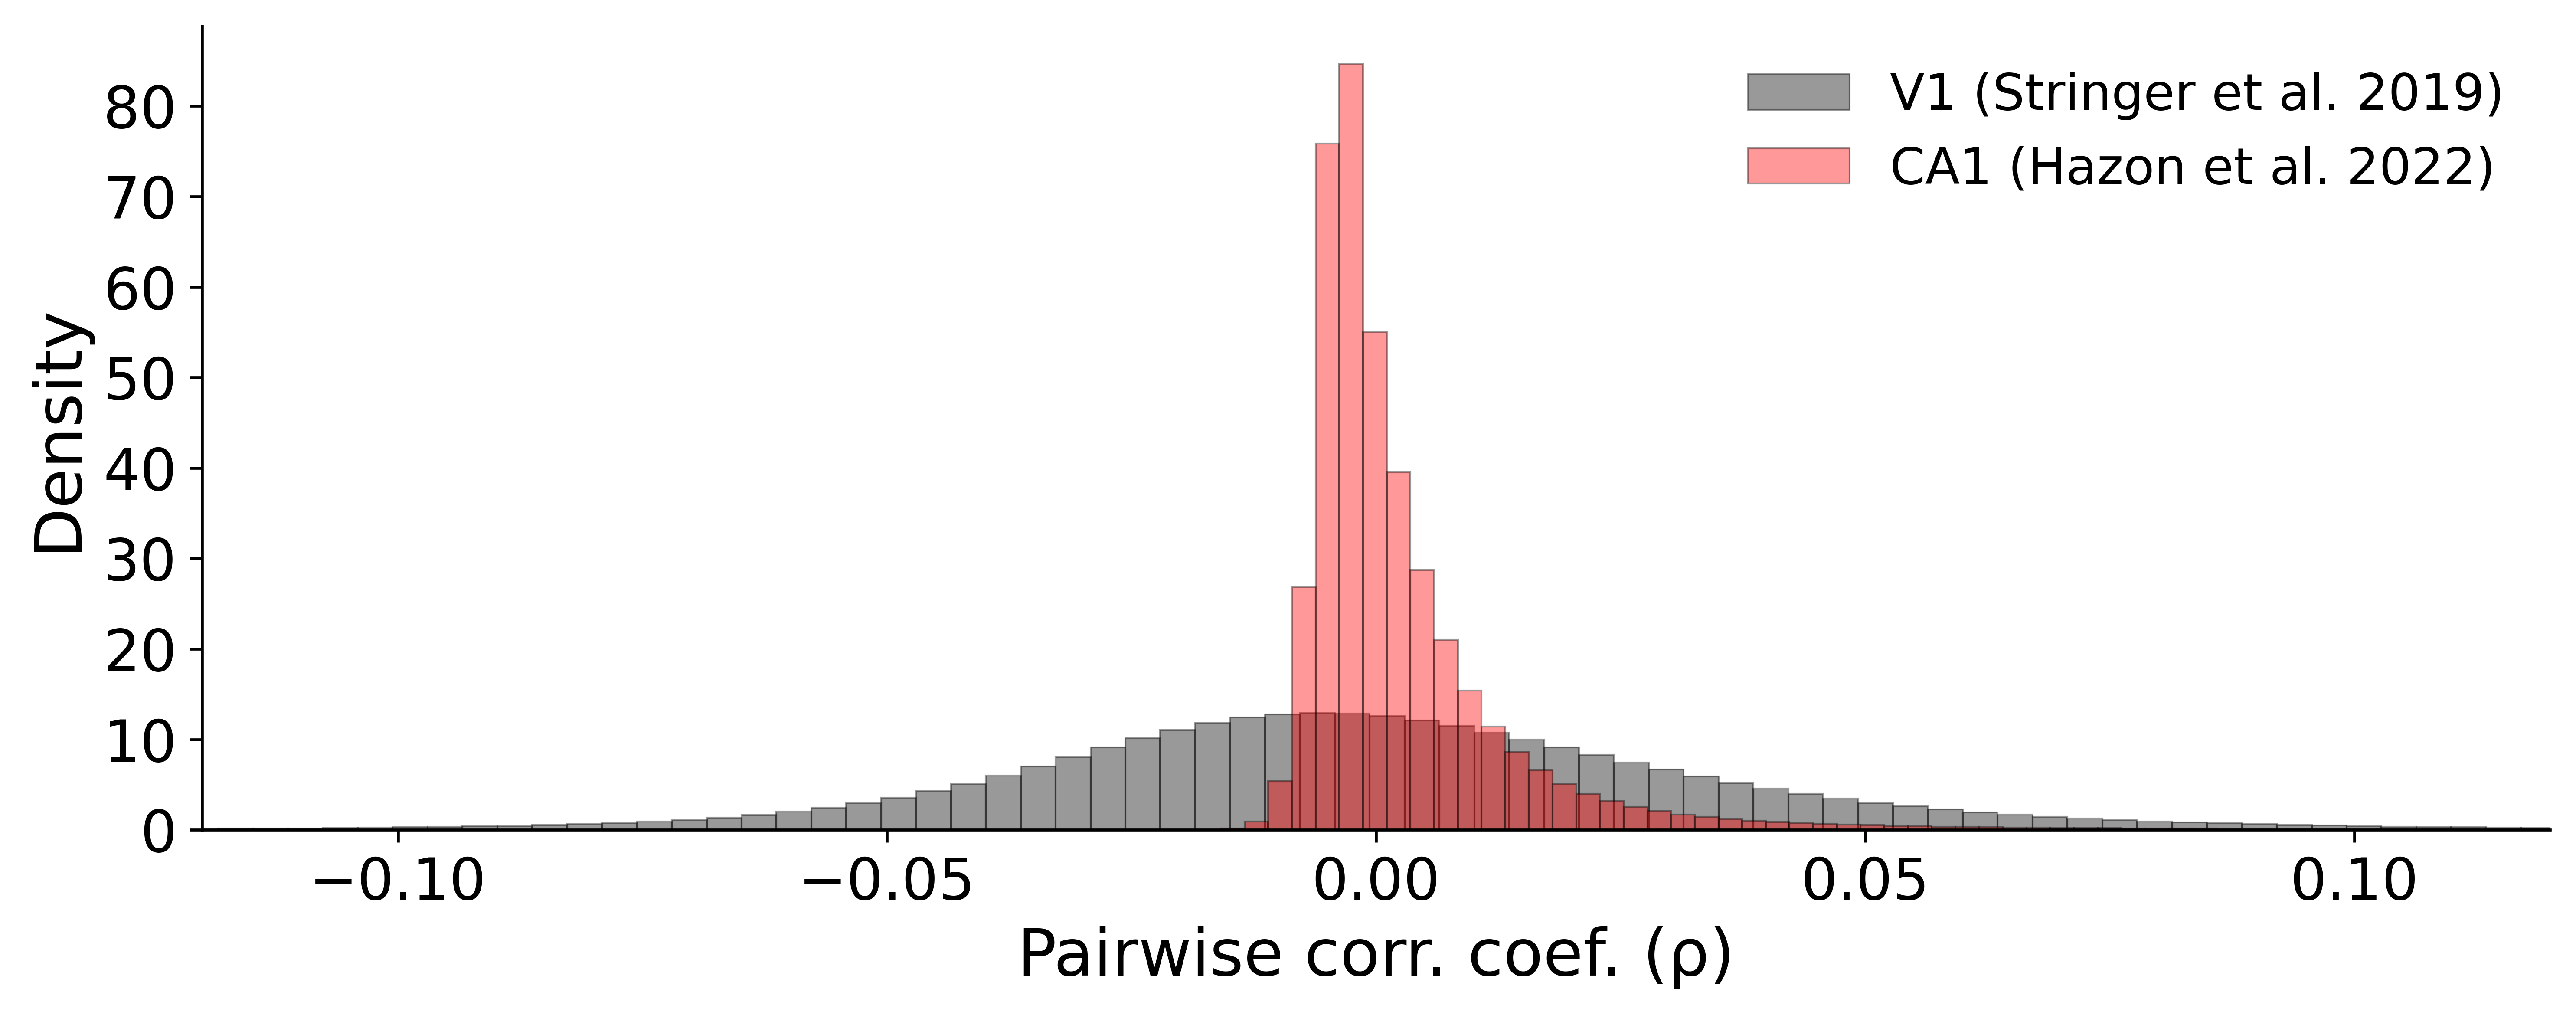

In [4]:
plt.figure(figsize=(10,4), dpi=600)

plt.hist(correlations_v1, bins=400, color='k', alpha=.4, edgecolor='k', linewidth=.5, density=True, label='V1 (Stringer et al. 2019)')
plt.hist(correlations_ca1, bins=400, color='r', alpha=.4, edgecolor='k', linewidth=.5, density=True, label='CA1 (Hazon et al. 2022)')

#plt.axvline(x=np.mean(correlations_v1), color='k', linestyle='--')
#plt.axvline(x=np.mean(correlations_ca1), color='r', linestyle='--')

plt.xlabel('Pairwise corr. coef. (ρ)', fontsize=18)
#plt.ylabel('No. of neuron pairs', fontsize=18)
plt.ylabel('Density', fontsize=18)

#plt.title('V1', fontsize=22)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(-0.12, 0.12)

plt.legend(frameon=False, fontsize=14)

sb.despine()
plt.tight_layout()
plt.savefig('plots/pairwiseCorrDistr_V1vsCA1.png', dpi=600)
plt.show()